C:\Users\zacha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


[ 0.00027951 -0.00157089  0.00564554 -0.00245245  0.01437981  0.00392588
 -0.00968969 -0.00615795  0.00590807  0.00446056  0.00062814  0.00620823
 -0.02445898  0.01306947  0.00504701 -0.00901895  0.00799477  0.0047035
  0.0021817   0.00548736 -0.00731523 -0.00673815 -0.00776876  0.0056221
 -0.00691009  0.00651338 -0.00731442 -0.0056306   0.04290603  0.01044225
 -0.00508253 -0.0056921  -0.02549317 -0.00473033  0.00048859  0.00378129
  0.00480437  0.00172072  0.00187689 -0.00579248 -0.00536307  0.00021562
 -0.00280085  0.00802373 -0.02674341  0.00366824  0.00499366 -0.00360499
  0.0053685   0.00401729 -0.01128364  0.00563019  0.01426484  0.00381238
  0.00537246  0.00825642  0.00448102  0.0094612   0.0021675  -0.01077293
  0.03608142  0.00481603  0.00422083  0.00484143  0.01624129  0.00148703
  0.01241273  0.00306834  0.00078298  0.00426644  0.02838998  0.01837734
  0.00796226  0.00913922  0.00216066  0.00156921  0.01582652  0.00703736
  0.00167522  0.00599154  0.00767775  0.00193888  0.0

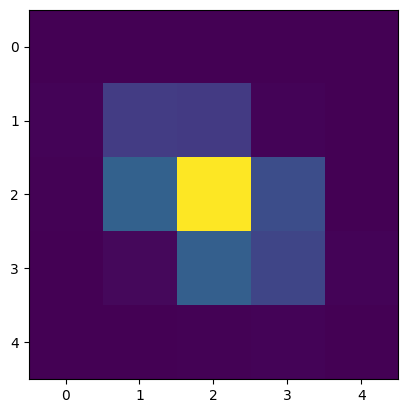

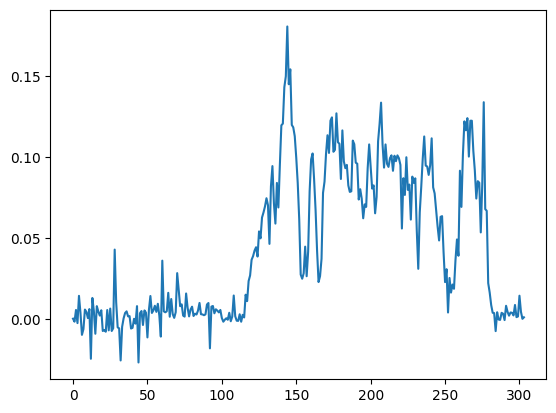

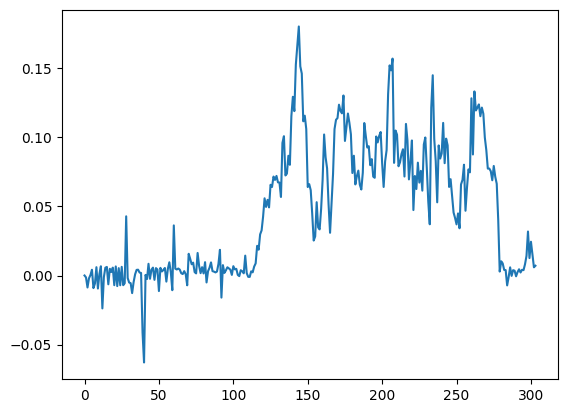

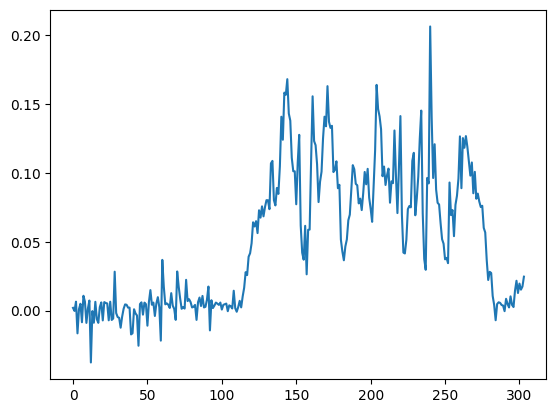

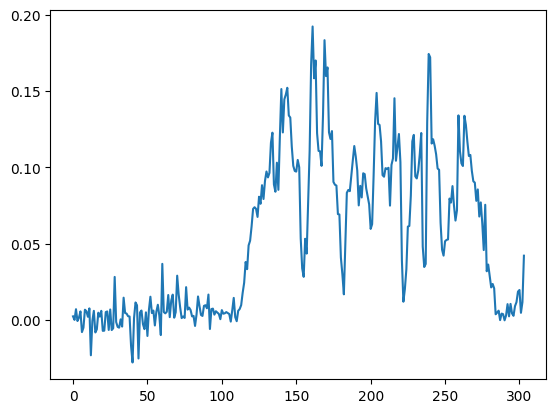

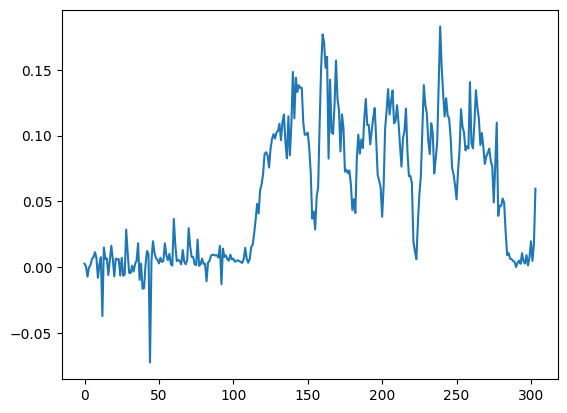

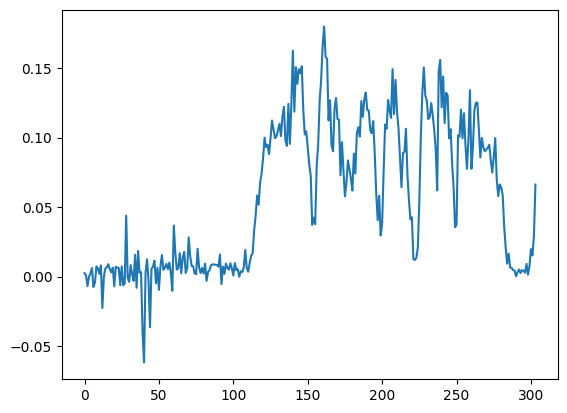

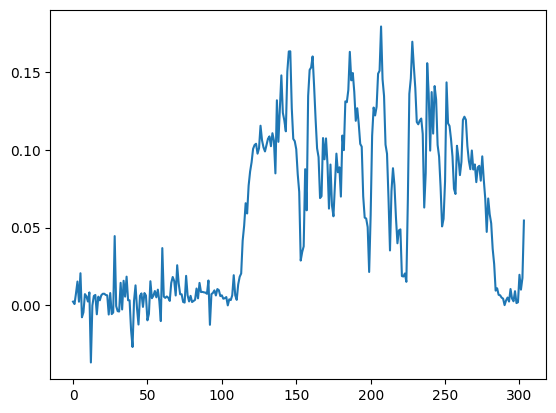

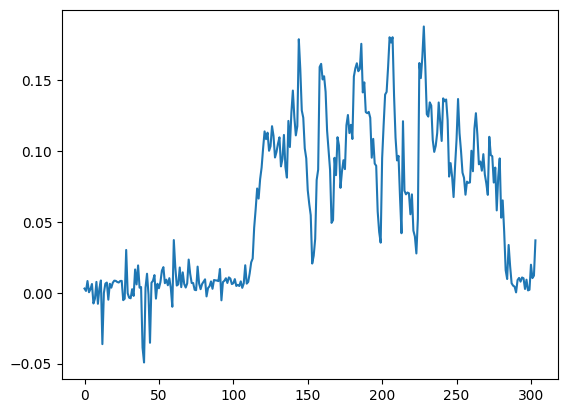

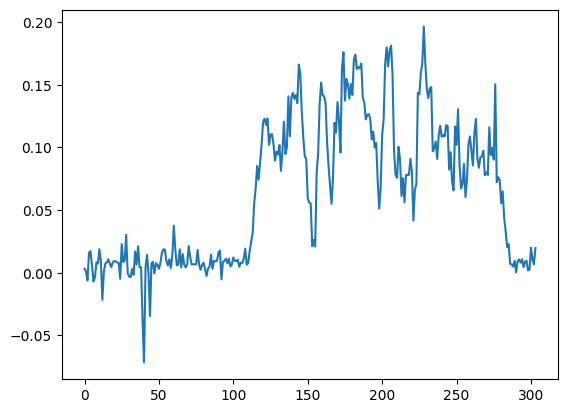

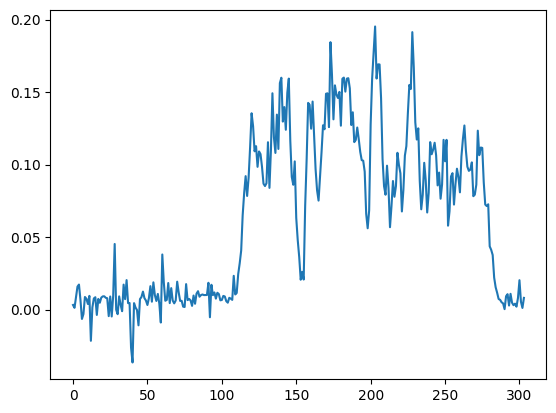

In [53]:
import numpy as np
import os
import pandas as pd
from HySpec_Image_Processing import HDR_Image
from fancy_spec_plot import fancy_spec_plot
import matplotlib.pyplot as plt
from spec_average import spec_avg
from scipy import interpolate as interp
import numpy.random as r
from scipy import signal
import spectral as sp
import tifffile as tf
from copy import copy


def plot_numpy_images(*args:np.ndarray,**kwargs:np.ndarray):
    defaultKwargs = {"titles":[],"figsize":(8,16)}
    kwargs = {**defaultKwargs,**kwargs}

    fig = plt.figure(figsize=kwargs.get("figsize"))
    col_num = len(args)
    for num,image in enumerate(args):
        ax = fig.add_subplot(1,col_num,num+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(kwargs.get('titles')[num])
        ax.imshow(image)

mu = np.array([0,0])
cov = np.array(([1,0.5],[0.5,1]))
multi=np.random.multivariate_normal(mu,cov,10000)
x,y = multi.T[0],multi.T[1]
dist = np.histogram2d(x,y,bins=5)
plt.imshow(dist[0])

def destripe(image):
    n=0
    for row in range(image.shape[0]):
        if n<10:
            print (image[row,:,0])
            fig = plt.figure()
            plt.plot(image[row,:,0])
        else:
            break
        n+=1

hdr = sp.envi.open(r'D:\Data/20230209T095534013597/extracted_files/hdr_files/m3g20090417t193320_v01_rfl/m3g20090417t193320_v01_rfl.hdr')
bandCenters = hdr.bands.centers
bandCenters = np.array(bandCenters)

allowedIndices = np.where((bandCenters>900)&(bandCenters<2600))[0]
allowedWvl = bandCenters[allowedIndices]

image = hdr.read_bands(allowedIndices)

destripe(image)